In [1]:
import warnings                                  # do not disturbe mode
warnings.filterwarnings('ignore')

# Load packages
import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

# Importing everything from forecasting quality metrics
from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
# MAPE
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        p_value = sm.tsa.stattools.adfuller(y)[1]
        ts_ax.set_title('Carnival Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
        plt.tight_layout()

In [3]:
# Get datasets from github repository
!wget https://raw.githubusercontent.com/danielhwei/DukeFinance/master/carnival_revenue.csv

--2020-08-07 17:04:27--  https://raw.githubusercontent.com/danielhwei/DukeFinance/master/carnival_revenue.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.200.133
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.200.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 975 [text/plain]
Saving to: ‘carnival_revenue.csv.1’

carnival_revenue.cs 100%[===================>]     975  --.-KB/s    in 0.009s  

2020-08-07 17:04:27 (105 KB/s) - ‘carnival_revenue.csv.1’ saved [975/975]



In [5]:
expenses = pd.read_csv('/Users/danielwei/Desktop/Duke Finance/carnival_revenue.csv', index_col=['Time'], parse_dates=['Time'])

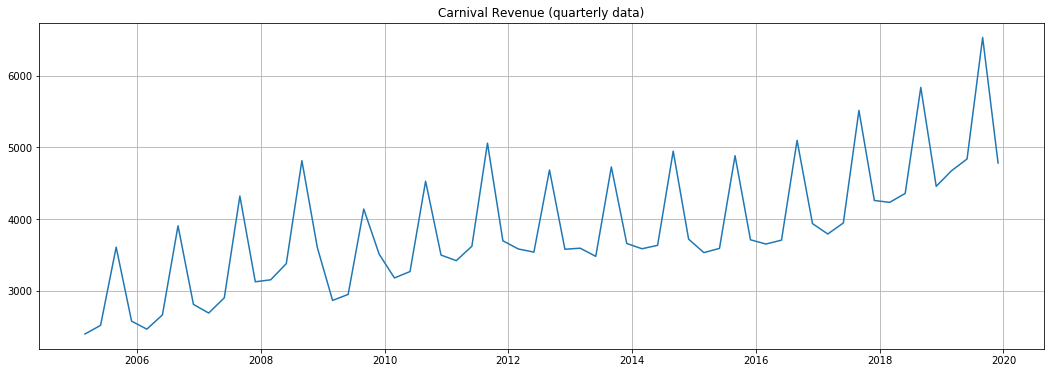

In [7]:
plt.figure(figsize=(18, 6))
plt.plot(expenses.Revenue)
plt.title('Carnival Revenue (quarterly data)')
plt.grid(True)
plt.show()

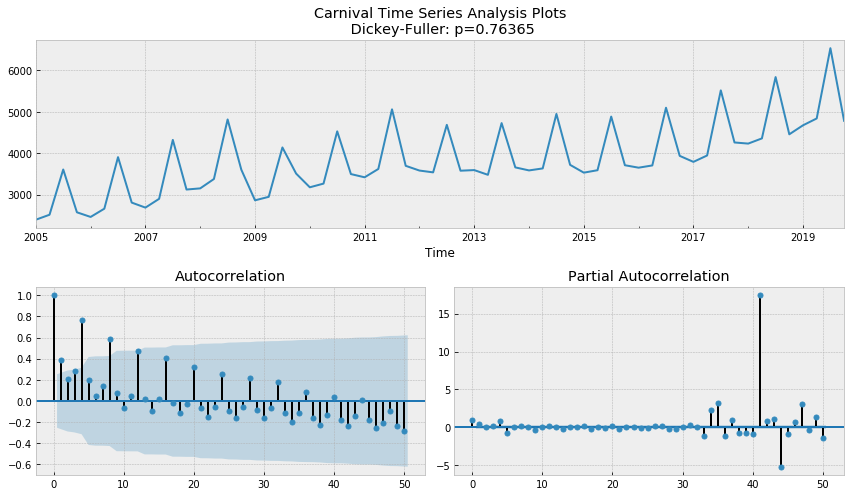

In [8]:
tsplot(expenses.Revenue, lags=50)

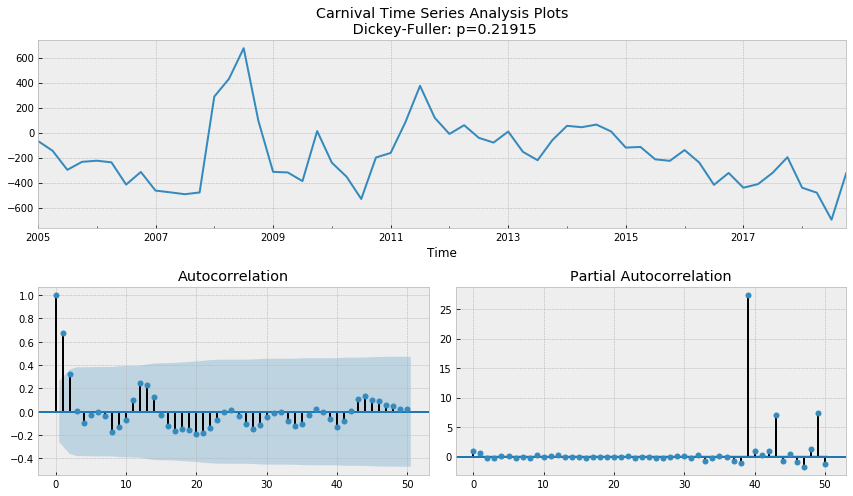

In [9]:
# The seasonal difference
netincome_diff = expenses.Revenue - expenses.Revenue.shift(4)
tsplot(netincome_diff[4:], lags=50)

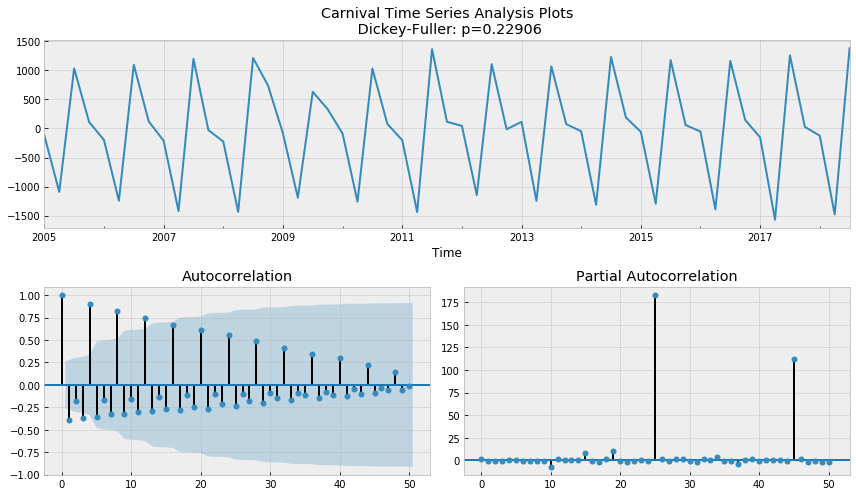

In [10]:
expenses_diff = expenses.Revenue - expenses.Revenue.shift(1)
tsplot(expenses_diff[4+1:], lags=50)

In [11]:
# setting initial values and some bounds for them
ps = range(2, 5)
d=1 
qs = range(2, 5)
Ps = range(0, 2)
D=1 
Qs = range(0, 2)
s = 4 # season length is still 24

# creating list with all the possible combinations of parameters
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

36

In [12]:
def optimizeSARIMA(y, parameters_list, d, D, s):
    """Return dataframe with parameters and corresponding AIC
        
        y - time series
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order in ARIMA model
        D - seasonal integration order 
        s - length of season
    """
    
    results = []
    best_aic = float("inf")

    for param in tqdm_notebook(parameters_list):
        # we need try-except because on some combinations model fails to converge
        try:
            model=sm.tsa.statespace.SARIMAX(y, order=(param[0], d, param[1]), 
                                            seasonal_order=(param[2], D, param[3], s)).fit(disp=-1)
        except:
            continue
        aic = model.aic
        # saving best model, AIC and parameters
        if aic < best_aic:
            best_model = model
            best_aic = aic
            best_param = param
        results.append([param, model.aic])

    result_table = pd.DataFrame(results)
    result_table.columns = ['parameters', 'aic']
    # sorting in ascending order, the lower AIC is - the better
    result_table = result_table.sort_values(by='aic', ascending=True).reset_index(drop=True)
    
    return result_table

In [14]:
%%time
warnings.filterwarnings("ignore") 
result_table = optimizeSARIMA(expenses.Revenue, parameters_list, d, D, s)


CPU times: user 6.93 s, sys: 88.4 ms, total: 7.02 s
Wall time: 7.06 s


In [15]:
result_table.head()

,parameters,aic
0,"(2, 3, 0, 1)",732.457632
1,"(3, 3, 0, 1)",733.388278
2,"(3, 2, 0, 1)",734.556778
3,"(4, 2, 0, 1)",734.764501
4,"(2, 4, 0, 0)",735.261760


In [16]:
# set the parameters that give the lowest AIC
p, q, P, Q = result_table.parameters[0]

best_model=sm.tsa.statespace.SARIMAX(expenses.Revenue, order=(p, d, q), 
                                        seasonal_order=(P, D, Q, s)).fit(disp=-1)
print(best_model.summary())

                                      SARIMAX Results                                      
Dep. Variable:                             Revenue   No. Observations:                   60
Model:             SARIMAX(2, 1, 3)x(0, 1, [1], 4)   Log Likelihood                -359.229
Date:                             Fri, 07 Aug 2020   AIC                            732.458
Time:                                     17:06:39   BIC                            746.509
Sample:                                          0   HQIC                           737.891
                                              - 60                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8910      0.280     -3.184      0.001      -1.439      -0.343
ar.L2         -0.2595      

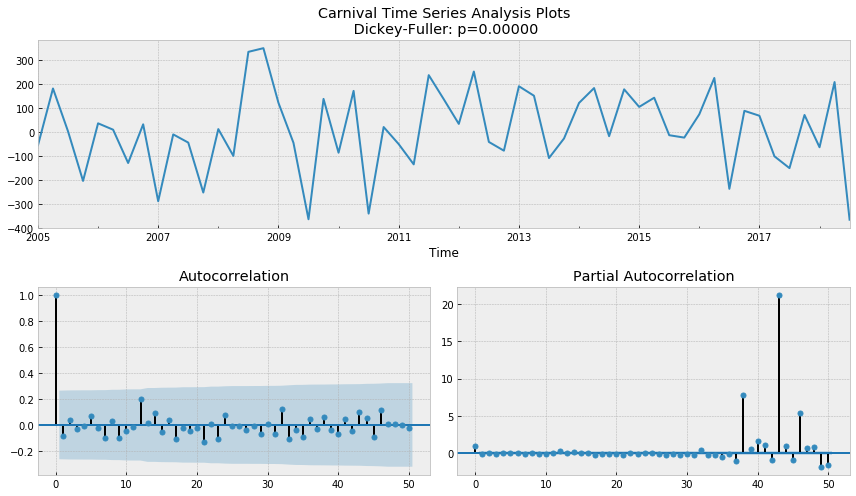

In [17]:
tsplot(best_model.resid[4+1:], lags=50)

In [18]:
def plotSARIMA(series, model, n_steps):
    """Plots model vs predicted values
        
        series - dataset with timeseries
        model - fitted SARIMA model
        n_steps - number of steps to predict in the future    
    """
    
    # adding model values
    data = series.copy()
    data.columns = ['actual']
    data['sarima_model'] = model.fittedvalues
    # making a shift on s+d steps, because these values were unobserved by the model
    # due to the differentiating
    data['sarima_model'][:s+d] = np.NaN
    
    # forecasting on n_steps forward 
    forecast = model.predict(start = data.shape[0], end = data.shape[0]+n_steps)
    forecast = data.sarima_model.append(forecast)
    # calculate error, again having shifted on s+d steps from the beginning
    error = mean_absolute_percentage_error(data['actual'][s+d:], data['sarima_model'][s+d:])

    plt.figure(figsize=(15, 7))
    plt.title("Mean Absolute Percentage Error: {0:.2f}%".format(error))
    plt.plot(forecast, color='r', label="model")
    plt.axvspan(data.index[-1], forecast.index[-1], alpha=0.5, color='lightgrey')
    plt.plot(data.actual, label="actual")
    plt.legend()
    plt.grid(True)

TypeError: float() argument must be a string or a number, not 'Timestamp'

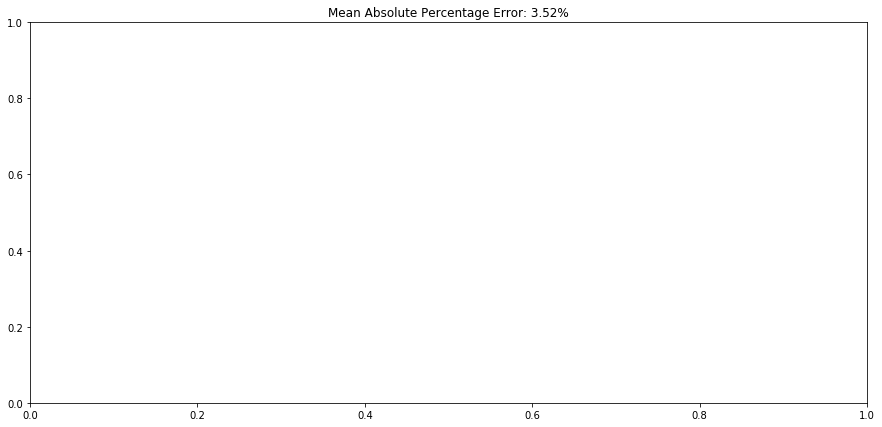

In [19]:
plotSARIMA(expenses, best_model, 50)